In [1]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
import h5py
import os
from pathlib import Path

import misc

data_dir = Path('/groups/douglase/kians-data-files/disk-processing')

wavelength_c = 825e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

# define desired PSF dimensions and pixelscale in units of lambda/D
npsf=150
psf_pixelscale_mas = 20.8*u.mas/u.pix
psf_pixelscale_lamD = psf_pixelscale_mas.value / mas_per_lamD.value
psf_pixelscale = 13e-6 * psf_pixelscale_lamD/(1/2)
psf_pixelscale_m = psf_pixelscale*u.m/u.pix

iwa = 6
owa = 20

# Load PSFs

(2497, 150, 150) 2497


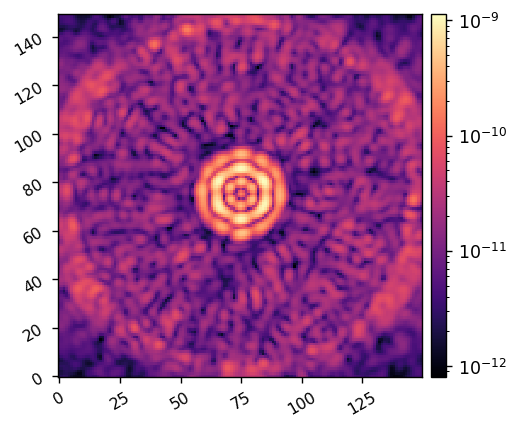

In [4]:
psfs_fpath = data_dir/'psfs'/'spcw_band4_psfs_20220922.fits'

psfs = fits.getdata(psfs_fpath)
print(psfs.shape, len(psfs))

misc.myimshow(psfs[0], lognorm=True)

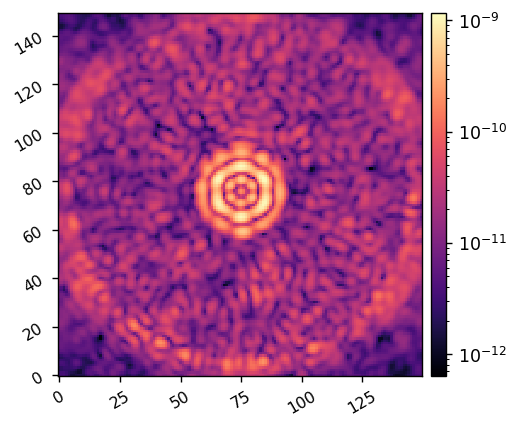

In [5]:
for i,psf in enumerate(psfs):
    try:
        misc.myimshow(psf, lognorm=True)
        clear_output(wait=True)
        time.sleep(0.25)
    except KeyboardInterrupt: 
        break

In [8]:
from matplotlib import patches

In [ ]:
r_offsets

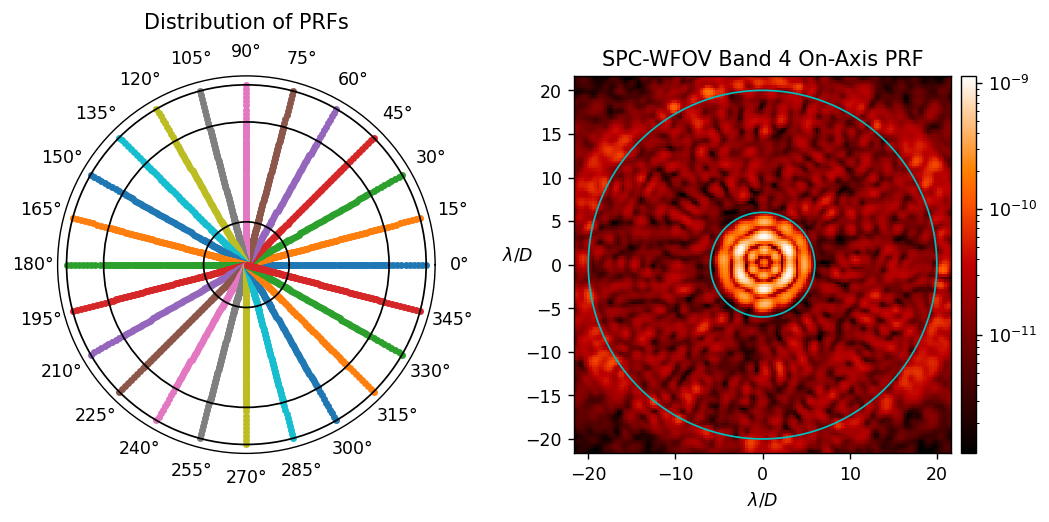

In [57]:
r_offsets_fpath = data_dir/'psfs'/'spcw_band4_psfs_radial_samples.fits'
thetas_fpath = data_dir/'psfs'/'spcw_band4_psfs_theta_samples.fits'

r_offsets = fits.getdata(r_offsets_fpath)
thetas = fits.getdata(thetas_fpath)*u.degree

# Plotting field angles
theta_offsets = []
for r in r_offsets[1:]:
    theta_offsets.append(thetas.to(u.radian).value)
theta_offsets = np.array(theta_offsets)
theta_offsets.shape

fig = plt.figure(dpi=125, figsize=(10,4))

ax1 = plt.subplot(121, projection='polar')
ax1.plot(theta_offsets, r_offsets[1:], '.', )
ax1.set_yticklabels([] )
ax1.set_rticks([iwa, owa, max(r_offsets)], color='r')  # Less radial ticks
# ax1.set_yticks([iwa, owa, max(r_offsets)],) 
ax1.set_rlabel_position(55)  # Move radial labels away from plotted line
ax1.set_thetagrids(thetas.value)
ax1.grid(axis='x', visible=False)
ax1.grid(axis='y', color='black', linewidth = 1)
ax1.set_title('Distribution of PRFs', va='bottom')
ax1.set_axisbelow(False)

ax2 = plt.subplot(122)
ext = [-psf_pixelscale_lamD*npsf/2, psf_pixelscale_lamD*npsf/2,
       -psf_pixelscale_lamD*npsf/2, psf_pixelscale_lamD*npsf/2]
im = ax2.imshow(psfs[0], norm=LogNorm(vmin=psfs[0].max()/1e3), cmap='gist_heat', extent=ext)
ax2.add_patch(Circle((0, 0), iwa, color='c', fill=False))
ax2.add_patch(Circle((0, 0), owa, color='c', fill=False))
ax2.set_title('SPC-WFOV Band 4 On-Axis PRF')
ax2.set_xlabel('$\lambda/D$')
ax2.set_ylabel('$\lambda/D$', rotation=0)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.075)
fig.colorbar(im, cax=cax)

# Setup/Test the interpolating function

In [7]:
r_offsets_mas = r_offsets * mas_per_lamD

# def find_closest_psf(xoff, yoff, verbose=True):
#     r = np.sqrt(xoff**2+yoff**2)
#     theta = np.arctan2(yoff,xoff).to(u.deg)
#     if theta<0: theta += 360*u.deg
        
#     kr = np.argmin(np.abs(r_offsets_mas-r))
#     if kr>(len(r_offsets)-1):
#         kr = len(r_offsets)-1
#     kth = np.argmin(np.abs(thetas-theta))
#     theta_diff = theta - thetas[kth] # use this to rotate the closest available PSF to the coordinate of interest
    
#     if kr==0: 
#         kpsf=0
#     else: 
#         kpsf = 1 + kth + (len(thetas))*(kr-1)
    
#     if verbose: 
#         print('Desired r={:.2f}, radial index={:d}, closest available r={:.2f}'.format(r, kr, r_offsets_mas[kr]))
#         print('Desired th={:.2f}, theta index={:d}, closest available th={:.2f}, difference={:.2f}'.format(theta, kth, thetas[kth], theta_diff))
#         print('PSF index = {:d}'.format(kpsf))
    
#     closest_psf = psfs[kpsf]
#     interpped_psf = rotate(closest_psf, -theta_diff.value, reshape=False, order=5)
    
#     return interpped_psf

# def find_closest_psf(xoff, yoff, verbose=True):
#     r = np.sqrt(xoff**2+yoff**2)
#     theta = np.arctan2(yoff,xoff).to(u.deg)
#     if theta<0: theta += 360*u.deg
        
#     kr = np.argmin(np.abs(r_offsets_mas-r))
#     kth = np.argmin(np.abs(thetas-theta))
#     theta_diff = theta - thetas[kth] # use this to rotate the closest available PSF to the coordinate of interest
    
#     if kr==0: kpsf=0
#     else: 
#         kpsf = 1 + kth + (len(thetas))*(kr-1)
    
#     if verbose: 
#         print('Desired r={:.2f}, radial index={:d}, closest available r={:.2f}'.format(r, kr, r_offsets_mas[kr]))
#         print('Desired th={:.2f}, theta index={:d}, closest available th={:.2f}, difference={:.2f}'.format(theta, kth, thetas[kth], theta_diff))
#         print('PSF index = {:d}'.format(kpsf))
    
#     closest_psf = psfs[kpsf]
#     interpped_psf = rotate(closest_psf, -theta_diff.value, reshape=False, order=0)
    
#     return interpped_psf

def find_closest_psf(xoff, yoff, verbose=True):
    r = np.sqrt(xoff**2+yoff**2)
    theta = np.arctan2(yoff,xoff).to(u.deg)
    if theta<0: theta += 360*u.deg
        
    kr = np.argmin(np.abs(r_offsets_mas-r))
    kth = np.argmin(np.abs(thetas-theta))
    theta_diff = theta - thetas[kth] # use this to rotate the closest available PSF to the coordinate of interest
    
    if kr==0: kpsf=0
    else: 
        kpsf = 1 + kth + (len(thetas))*(kr-1)
    
    if verbose: 
        print('Desired r={:.2f}, radial index={:d}, closest available r={:.2f}'.format(r, kr, r_offsets_mas[kr]))
        print('Desired th={:.2f}, theta index={:d}, closest available th={:.2f}, difference={:.2f}'.format(theta, kth, thetas[kth], theta_diff))
        print('PSF index = {:d}'.format(kpsf))
    
    closest_psf = psfs[kpsf]
    interpped_psf = rotate(closest_psf, -theta_diff.value, reshape=False, order=1)
    
    return interpped_psf

Desired r=800.00 mas, radial index=63, closest available r=795.27 mas
Desired th=200.00 deg, theta index=13, closest available th=195.00 deg, difference=5.00 deg
PSF index = 1502


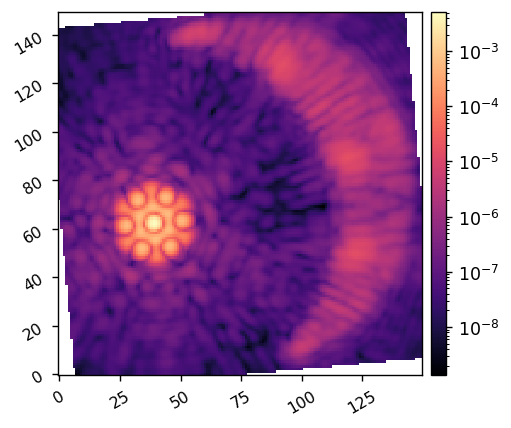

In [8]:
r = 800*u.mas
th = 200*u.deg
xoff = r*np.cos(th)
yoff = r*np.sin(th)
psf = find_closest_psf(xoff,yoff)

misc.myimshow(psf, lognorm=True)

# Create the grid for which the interpolated PSFs will be calculated

In [9]:
ndisk = 150
disk_pixelscale_mas = 20.8*u.mas/u.pix

x,y = np.meshgrid(np.arange(-ndisk/2,ndisk/2) + 1/2, np.arange(-ndisk/2,ndisk/2)+1/2 )
x = x.flatten()*disk_pixelscale_mas*u.pix
y = y.flatten()*disk_pixelscale_mas*u.pix
x

<Quantity [-1549.6, -1528.8, -1508. , ...,  1508. ,  1528.8,  1549.6] mas>

Desired r=2191.47 mas, radial index=104, closest available r=1814.61 mas
Desired th=225.00 deg, theta index=15, closest available th=225.00 deg, difference=0.00 deg
PSF index = 2488


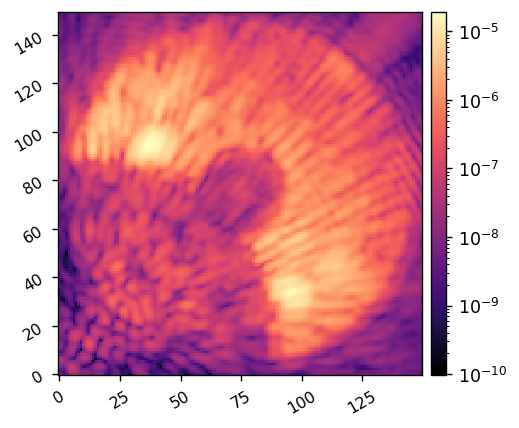

In [10]:
xoff = x[0]
yoff = y[0]
psf = find_closest_psf(xoff,yoff)

misc.myimshow(psf, lognorm=True)

In [16]:
ncols = ndisk**2
ipsf_matrix = np.zeros((npsf**2, ncols))

start=time.time()
for i in range(ncols):
    ipsf = find_closest_psf(x[i], y[i], verbose=False)
    ipsf_matrix[:,i] = ipsf.flatten() # assign the flattened psf to the column
    if i==ncols/8 or i==ncols/4 or i==ncols/2 or i==ncols*3/4 or i==ncols*7/8 or i==ncols-1:
        clear_output()
        print(i, time.time()-start)

22499 27.046013832092285


In [17]:
ipsf_fpath = data_dir/'ipsfs'/'spcw_band4_ipsfs_20220920.hdf5'
f = h5py.File(ipsf_fpath,'w')
f.create_dataset('ipsf_matrix', data=ipsf_matrix)
f.close()